# TP - Introduction à NoSQL

## Écriture de données

1.1)

In [ ]:
import sqlite3
from pymongo import MongoClient

locs = []

con = sqlite3.connect('pokedex (1).sqlite') 

for [id, identifier, regionId] in con.cursor().execute('select id, identifier, region_id from locations'):
	# create object with basic entries
	loc = { 'id': id, 'identifier': identifier, 'name': {}, 'areas': [], 'encounters': [] }

	# add name entry to object (as language map)
	langQuery = 'select local_language_id, name from location_names where local_language_id in (5, 9) and location_id = "{}"'.format(id)
	for [langId, name] in con.cursor().execute(langQuery):
		if langId == 5:
			loc['name']['fr'] = name
		elif langId == 9:
			loc['name']['en'] = name

	# add region entry to object
	if regionId != None:
		regionQuery = 'select identifier from regions where id = "{}"'.format(regionId)
		region = con.cursor().execute(regionQuery).fetchone()[0]
		loc['region'] = region

	# add area list to object
	areasQuery = 'select id, identifier from location_areas where location_id = "{}"'.format(id)
	for [areaId, areaIdentifier] in con.cursor().execute(areasQuery):
		if areaIdentifier != None:
			loc['areas'].append(areaIdentifier)

		# add Pokémon encounter list to location (aggregating for all areas in the location)
		encountersQuery = 'select distinct p.identifier from encounters as e, pokemon as p where e.pokemon_id = p.id and e.location_area_id = "{}"'.format(areaId)
		for [pokemonIdentifier] in con.cursor().execute(encountersQuery):
			if not pokemonIdentifier in loc['encounters']:
				loc['encounters'].append(pokemonIdentifier)

	# append object to list of locations
	locs.append(loc)

# check that object creation ran without error
assert len(locs) == 781
print(locs[15])

# load all objects to MongoDB using pyMongo
client = MongoClient('mongodb://localhost:27017/')
pokedex = client['pokedex']['inventory']

for loc in locs:
	loc['_id'] = loc['id'] # _id is interpreted by MongoDB as the document's key
	pokedex.insert_one(loc)


In [ ]:
# TODO query MongoDB using pokedex.find_one() and pokedex.find()
# see also https://pymongo.readthedocs.io/en/stable/tutorial.html#getting-a-single-document-with-find-one
# see also https://pymongo.readthedocs.io/en/stable/tutorial.html#querying-for-more-than-one-document

## Lecture de données

In [6]:
from pymongo import MongoClient

class Connect(object):
    @staticmethod    
    def get_connection():
        return MongoClient('mongodb://localhost:27017/')
    


In [9]:

client = Connect.get_connection()


In [25]:
db = client.pokedex

In [156]:
 # On filtre les lieux de la region de kanto et on projette uniquement la clé encouters afin de récupérer la liste des pokemons

pipeline = [
   {
      "$match": {
         "region": "kanto"
      }
   }, 
   {
      "$project": {
         "encounters": 1, '_id': 0
      }
   },
]

In [157]:

pokemonPresent = db.inventory.aggregate(pipeline)


On décortique le résultat pour obtenir le nombre d'occurence pour chaque pokemon sous forme de liste

In [158]:
from pprint import pprint
listApparitionPokemon = []

for pokemons in pokemonPresent:
        listPoke = pokemons["encounters"] # on accède aux valeurs de la clé encounters
        for poke in listPoke:
            listApparitionPokemon.append(poke) 

In [159]:
print(listApparitionPokemon)

['grimer', 'muk', 'magikarp', 'goldeen', 'poliwag', 'poliwhirl', 'slowpoke', 'psyduck', 'koffing', 'eevee', 'goldeen', 'seaking', 'magikarp', 'poliwag', 'psyduck', 'krabby', 'horsea', 'gyarados', 'tentacool', 'slowpoke', 'bulbasaur', 'tentacool', 'tentacruel', 'magikarp', 'chinchou', 'shellder', 'lanturn', 'goldeen', 'poliwag', 'staryu', 'horsea', 'krabby', 'gyarados', 'seadra', 'psyduck', 'slowbro', 'slowpoke', 'diglett', 'absol', 'bronzor', 'makuhita', 'chingling', 'dugtrio', 'magikarp', 'gyarados', 'goldeen', 'poliwag', 'seaking', 'krabby', 'psyduck', 'slowpoke', 'zubat', 'geodude', 'absol', 'bronzor', 'sandshrew', 'makuhita', 'chingling', 'paras', 'sandslash', 'clefairy', 'poliwag', 'magikarp', 'tentacool', 'tentacruel', 'magikarp', 'chinchou', 'shellder', 'lanturn', 'goldeen', 'poliwag', 'staryu', 'horsea', 'krabby', 'gyarados', 'seadra', 'psyduck', 'kingler', 'slowpoke', 'bulbasaur', 'charmander', 'squirtle', 'pikachu', 'cubone', 'geodude', 'absol', 'bronzor', 'machop', 'makuhita

In [181]:
from collections import Counter
nbOccurencePoke = Counter(listApparitionPokemon) # on compte le nombre d'occurence pour chaque pokemon
nbOccurencePokeTrie = sorted(x.items(), key=lambda pair: pair[1], reverse=True) # on trie nos resultats par ordre croissant
print(nbOccurencePokeTrie)

[('magikarp', 50), ('slowpoke', 44), ('psyduck', 44), ('gyarados', 41), ('krabby', 36), ('tentacool', 35), ('goldeen', 31), ('poliwag', 31), ('horsea', 30), ('tentacruel', 25), ('seadra', 25), ('kingler', 24), ('pidgey', 19), ('spearow', 18), ('shellder', 17), ('rattata', 17), ('pidgeotto', 17), ('raticate', 15), ('fearow', 15), ('meowth', 14), ('poliwhirl', 13), ('oddish', 13), ('bellsprout', 13), ('plusle', 12), ('shinx', 12), ('minun', 12), ('whismur', 12), ('buizel', 12), ('linoone', 12), ('bidoof', 12), ('seaking', 11), ('staryu', 11), ('zubat', 11), ('venonat', 11), ('venomoth', 11), ('noctowl', 11), ('qwilfish', 11), ('gloom', 11), ('weepinbell', 11), ('persian', 11), ('mankey', 10), ('hoppip', 9), ('remoraid', 9), ('slowbro', 8), ('geodude', 8), ('sandshrew', 8), ('golbat', 8), ('doduo', 8), ('ponyta', 8), ('arbok', 8), ('chinchou', 7), ('lanturn', 7), ('sandslash', 7), ('marowak', 7), ('graveler', 7), ('quagsire', 7), ('ekans', 7), ('unown', 7), ('grimer', 6), ('muk', 6), ('ab

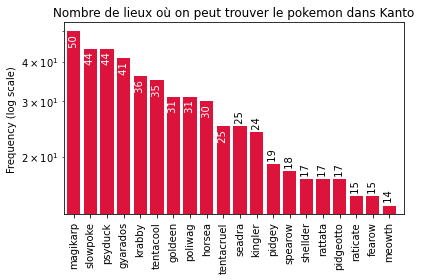

In [195]:
import numpy as np
from matplotlib import pyplot as plt


y = [count for tag, count in nbOccurencePoke.most_common(20)]
x = [tag for tag, count in nbOccurencePoke.most_common(20)]

plt.bar(x, y, color='crimson')
plt.title("Nombre de lieux où on peut trouver le pokemon dans Kanto")
plt.ylabel("Frequency (log scale)")
plt.yscale('log') 
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(nbOccurencePoke.most_common(20)):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
plt.xlim(-0.6, len(x)-0.10)
plt.tight_layout() 
plt.show()

In [201]:
nbLieux = len(cursor.distinct("identifier"))# on compte le nb de lieux en excluant d'eventuel doublon nombre de lieux dans Kanto
print("Il y a {} dans la région de Kanto".format(nbLieux))

Il y a 85 dans la région de Kanto


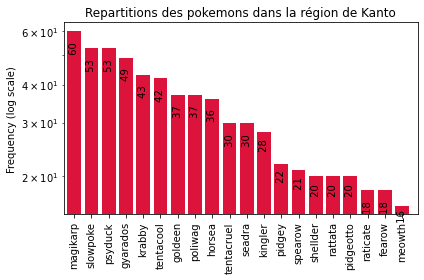

In [221]:
import numpy as np
from matplotlib import pyplot as plt


y = [int((count/83)*100) for tag, count in nbOccurencePoke.most_common(20)] # on prend la parte entière du pourcentage de repartition
x = [tag for tag, count in nbOccurencePoke.most_common(20)]

plt.bar(x, y, color='crimson')
plt.title("Repartitions des pokemons dans la région de Kanto")
plt.ylabel("Frequency (log scale)")
plt.yscale('log') 
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(nbOccurencePoke.most_common(20)):
    plt.text(i, count, f' {int((count/83)*100)} ', rotation=90,
             ha='center')
plt.xlim(-0.6, len(x)-0.10)
plt.tight_layout() 
plt.show()